In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
torch.__version__

'1.6.0'

In [3]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [4]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [5]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [6]:
EPS32 = (1.0 + np.finfo(np.float32).eps)
def histogram2d_engine(raw, npt, 
                       radial_range=None,
                       azimuth_range=None
                       ):
    """Implementation of 2D rebinning engine using pure numpy histograms
    
    :param npt: number of points to integrate over in (azimuthal, radial) dimension
    :param raw: 2D array with the raw signal
    """
    
    shape = raw.shape
    y = np.linspace(-shape[0] / 2, shape[0] / 2, shape[0])
    x = np.linspace(-shape[1] / 2, shape[1] / 2, shape[1])
    yy, xx = np.meshgrid(y, x, indexing='ij')
    
    radial = (yy**2 + xx**2)**0.5
    azimuth = np.arctan2(yy, xx)
    
    raw = np.ascontiguousarray(raw.ravel())
    radial = radial.ravel()
    azimuth = azimuth.ravel()
    
    if radial_range is None:
        radial_range = (radial.min(), radial.max() * EPS32)
    if azimuth_range is None:
        azimuth_range = (azimuth.min(), azimuth.max() * EPS32)
    
    histo_count, position_azim, position_rad = np.histogram2d(azimuth, radial, npt, weights=raw, range=[azimuth_range, radial_range])

    bins_azim = (position_azim[1:] + position_azim[:-1]) / 2.0
    bins_rad = (position_rad[1:] + position_rad[:-1]) / 2.0
    return histo_count, bins_azim, bins_rad

In [7]:
torch.cuda.device_count()

2

In [8]:
EPOCHS = 20
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = 1e-3 
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.001


In [9]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [10]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [11]:
real_space = np.load('../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [12]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [161]:
try:
    
    data_diffr_red = np.load('../data/20191008_39_diff_azimuth.npz')['arr_0']
except:
    data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']

    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            histo_count_2d, bins_azim, bins_rad = histogram2d_engine(data_diffr[i,j]**2, (64, 94))
            data_diffr_red[i,j] = histo_count_2d[:,:64]#resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            #data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3, 0, data_diffr_red[i,j])
    np.savez_compressed('../data/20191008_39_diff_azimuth.npz', data_diffr_red)

  0%|          | 0/161 [00:00<?, ?it/s]

(161, 161, 256, 256)


100%|██████████| 161/161 [02:31<00:00,  1.06it/s]


In [162]:
data_diffr_red = np.log(data_diffr_red + 1)

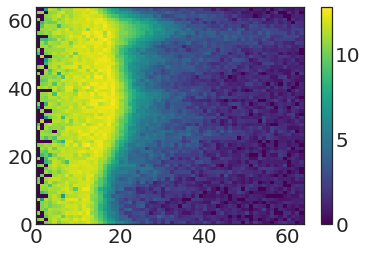

In [163]:
plt.pcolormesh(data_diffr_red[0,0])
plt.colorbar()
plt.show()

In [164]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [165]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [166]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [167]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [168]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [169]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [170]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 32, 64, 64]          320
|    └─ReLU: 2-2                         [-1, 32, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 32, 64, 64]          9,248
|    └─ReLU: 2-4                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-7                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-8                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-9                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-10                   [-1, 64, 16, 16]          --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-12                        [-1, 128, 16, 16]         --

In [171]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()#
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 100, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, min_lr=LR / 10)

LR step size is: 720.0 which is every 6 epochs


In [172]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [173]:
scaler = torch.cuda.amp.GradScaler()

In [174]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
       
        #print(loss)
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()
        
        

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        #print(loss)
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [175]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [184]:

#train(trainloader,metrics)

for epoch in range (200):#EPOCHS):

  
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

120it [00:17,  6.89it/s]


Saving improved model after Val Loss improved from 0.53182 to 0.53132
Epoch: 0 | FT  | Train Loss: 0.43368 | Val Loss: 0.53132
Epoch: 0 | Amp | Train Loss: 0.0075 | Val Loss: 0.0086
Epoch: 0 | Ph  | Train Loss: 0.426 | Val Loss: 0.523
Epoch: 0 | Ending LR: 0.000120 


120it [00:16,  7.06it/s]


Saving improved model after Val Loss improved from 0.53132 to 0.52836
Epoch: 1 | FT  | Train Loss: 0.43070 | Val Loss: 0.52836
Epoch: 1 | Amp | Train Loss: 0.0075 | Val Loss: 0.0087
Epoch: 1 | Ph  | Train Loss: 0.423 | Val Loss: 0.520
Epoch: 1 | Ending LR: 0.000127 


120it [00:16,  7.07it/s]


Epoch: 2 | FT  | Train Loss: 0.42595 | Val Loss: 0.53398
Epoch: 2 | Amp | Train Loss: 0.0075 | Val Loss: 0.0086
Epoch: 2 | Ph  | Train Loss: 0.418 | Val Loss: 0.525
Epoch: 2 | Ending LR: 0.000106 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.52836 to 0.52003
Epoch: 3 | FT  | Train Loss: 0.41974 | Val Loss: 0.52003
Epoch: 3 | Amp | Train Loss: 0.0074 | Val Loss: 0.0086
Epoch: 3 | Ph  | Train Loss: 0.412 | Val Loss: 0.511
Epoch: 3 | Ending LR: 0.000086 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.52003 to 0.51460
Epoch: 4 | FT  | Train Loss: 0.41343 | Val Loss: 0.51460
Epoch: 4 | Amp | Train Loss: 0.0074 | Val Loss: 0.0086
Epoch: 4 | Ph  | Train Loss: 0.406 | Val Loss: 0.506
Epoch: 4 | Ending LR: 0.000065 


120it [00:17,  7.01it/s]


Saving improved model after Val Loss improved from 0.51460 to 0.50548
Epoch: 5 | FT  | Train Loss: 0.40871 | Val Loss: 0.50548
Epoch: 5 | Amp | Train Loss: 0.0074 | Val Loss: 0.0085
Epoch: 5 | Ph  | Train Loss: 0.401 | Val Loss: 0.497
Epoch: 5 | Ending LR: 0.000044 


120it [00:17,  7.05it/s]


Epoch: 6 | FT  | Train Loss: 0.40423 | Val Loss: 0.50853
Epoch: 6 | Amp | Train Loss: 0.0074 | Val Loss: 0.0086
Epoch: 6 | Ph  | Train Loss: 0.397 | Val Loss: 0.500
Epoch: 6 | Ending LR: 0.000024 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.50548 to 0.49983
Epoch: 7 | FT  | Train Loss: 0.40059 | Val Loss: 0.49983
Epoch: 7 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 7 | Ph  | Train Loss: 0.393 | Val Loss: 0.491
Epoch: 7 | Ending LR: 0.000013 


120it [00:17,  7.03it/s]


Epoch: 8 | FT  | Train Loss: 0.39971 | Val Loss: 0.50549
Epoch: 8 | Amp | Train Loss: 0.0073 | Val Loss: 0.0086
Epoch: 8 | Ph  | Train Loss: 0.392 | Val Loss: 0.497
Epoch: 8 | Ending LR: 0.000024 


120it [00:17,  6.92it/s]


Saving improved model after Val Loss improved from 0.49983 to 0.49981
Epoch: 9 | FT  | Train Loss: 0.40018 | Val Loss: 0.49981
Epoch: 9 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 9 | Ph  | Train Loss: 0.393 | Val Loss: 0.491
Epoch: 9 | Ending LR: 0.000034 


120it [00:17,  7.05it/s]


Epoch: 10 | FT  | Train Loss: 0.40016 | Val Loss: 0.50345
Epoch: 10 | Amp | Train Loss: 0.0073 | Val Loss: 0.0086
Epoch: 10 | Ph  | Train Loss: 0.393 | Val Loss: 0.495
Epoch: 10 | Ending LR: 0.000044 


120it [00:17,  7.04it/s]


Epoch: 11 | FT  | Train Loss: 0.40005 | Val Loss: 0.50579
Epoch: 11 | Amp | Train Loss: 0.0073 | Val Loss: 0.0086
Epoch: 11 | Ph  | Train Loss: 0.393 | Val Loss: 0.497
Epoch: 11 | Ending LR: 0.000055 


120it [00:17,  7.02it/s]


Epoch: 12 | FT  | Train Loss: 0.39902 | Val Loss: 0.50440
Epoch: 12 | Amp | Train Loss: 0.0073 | Val Loss: 0.0087
Epoch: 12 | Ph  | Train Loss: 0.392 | Val Loss: 0.496
Epoch: 12 | Ending LR: 0.000065 


120it [00:17,  7.06it/s]


Epoch: 13 | FT  | Train Loss: 0.39881 | Val Loss: 0.50069
Epoch: 13 | Amp | Train Loss: 0.0074 | Val Loss: 0.0086
Epoch: 13 | Ph  | Train Loss: 0.391 | Val Loss: 0.492
Epoch: 13 | Ending LR: 0.000068 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.49981 to 0.49610
Epoch: 14 | FT  | Train Loss: 0.39530 | Val Loss: 0.49610
Epoch: 14 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 14 | Ph  | Train Loss: 0.388 | Val Loss: 0.488
Epoch: 14 | Ending LR: 0.000058 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.49610 to 0.49260
Epoch: 15 | FT  | Train Loss: 0.39227 | Val Loss: 0.49260
Epoch: 15 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 15 | Ph  | Train Loss: 0.385 | Val Loss: 0.484
Epoch: 15 | Ending LR: 0.000048 


120it [00:17,  7.02it/s]


Epoch: 16 | FT  | Train Loss: 0.38870 | Val Loss: 0.49693
Epoch: 16 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 16 | Ph  | Train Loss: 0.381 | Val Loss: 0.488
Epoch: 16 | Ending LR: 0.000038 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.49260 to 0.48791
Epoch: 17 | FT  | Train Loss: 0.38573 | Val Loss: 0.48791
Epoch: 17 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 17 | Ph  | Train Loss: 0.378 | Val Loss: 0.479
Epoch: 17 | Ending LR: 0.000027 


120it [00:17,  6.92it/s]


Epoch: 18 | FT  | Train Loss: 0.38334 | Val Loss: 0.49076
Epoch: 18 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 18 | Ph  | Train Loss: 0.376 | Val Loss: 0.482
Epoch: 18 | Ending LR: 0.000017 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.48791 to 0.48522
Epoch: 19 | FT  | Train Loss: 0.38129 | Val Loss: 0.48522
Epoch: 19 | Amp | Train Loss: 0.0073 | Val Loss: 0.0084
Epoch: 19 | Ph  | Train Loss: 0.374 | Val Loss: 0.477
Epoch: 19 | Ending LR: 0.000012 


120it [00:17,  7.03it/s]


Epoch: 20 | FT  | Train Loss: 0.38086 | Val Loss: 0.48819
Epoch: 20 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 20 | Ph  | Train Loss: 0.374 | Val Loss: 0.480
Epoch: 20 | Ending LR: 0.000017 


120it [00:17,  7.01it/s]


Saving improved model after Val Loss improved from 0.48522 to 0.48491
Epoch: 21 | FT  | Train Loss: 0.38091 | Val Loss: 0.48491
Epoch: 21 | Amp | Train Loss: 0.0073 | Val Loss: 0.0084
Epoch: 21 | Ph  | Train Loss: 0.374 | Val Loss: 0.476
Epoch: 21 | Ending LR: 0.000022 


120it [00:17,  7.05it/s]


Epoch: 22 | FT  | Train Loss: 0.38111 | Val Loss: 0.48876
Epoch: 22 | Amp | Train Loss: 0.0073 | Val Loss: 0.0084
Epoch: 22 | Ph  | Train Loss: 0.374 | Val Loss: 0.480
Epoch: 22 | Ending LR: 0.000027 


120it [00:17,  7.04it/s]


Epoch: 23 | FT  | Train Loss: 0.38103 | Val Loss: 0.48975
Epoch: 23 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 23 | Ph  | Train Loss: 0.374 | Val Loss: 0.481
Epoch: 23 | Ending LR: 0.000032 


120it [00:17,  7.03it/s]


Epoch: 24 | FT  | Train Loss: 0.38046 | Val Loss: 0.48699
Epoch: 24 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 24 | Ph  | Train Loss: 0.373 | Val Loss: 0.478
Epoch: 24 | Ending LR: 0.000038 


120it [00:17,  7.00it/s]


Epoch: 25 | FT  | Train Loss: 0.37985 | Val Loss: 0.48941
Epoch: 25 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 25 | Ph  | Train Loss: 0.373 | Val Loss: 0.481
Epoch: 25 | Ending LR: 0.000039 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.48491 to 0.48060
Epoch: 26 | FT  | Train Loss: 0.37804 | Val Loss: 0.48060
Epoch: 26 | Amp | Train Loss: 0.0073 | Val Loss: 0.0084
Epoch: 26 | Ph  | Train Loss: 0.371 | Val Loss: 0.472
Epoch: 26 | Ending LR: 0.000034 


120it [00:17,  7.01it/s]


Epoch: 27 | FT  | Train Loss: 0.37568 | Val Loss: 0.48265
Epoch: 27 | Amp | Train Loss: 0.0072 | Val Loss: 0.0085
Epoch: 27 | Ph  | Train Loss: 0.368 | Val Loss: 0.474
Epoch: 27 | Ending LR: 0.000029 


120it [00:17,  7.02it/s]


Epoch: 28 | FT  | Train Loss: 0.37387 | Val Loss: 0.48640
Epoch: 28 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 28 | Ph  | Train Loss: 0.367 | Val Loss: 0.478
Epoch: 28 | Ending LR: 0.000024 


120it [00:17,  7.02it/s]


Epoch: 29 | FT  | Train Loss: 0.37265 | Val Loss: 0.48127
Epoch: 29 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 29 | Ph  | Train Loss: 0.365 | Val Loss: 0.473
Epoch: 29 | Ending LR: 0.000019 


120it [00:17,  6.99it/s]


Saving improved model after Val Loss improved from 0.48060 to 0.47974
Epoch: 30 | FT  | Train Loss: 0.37101 | Val Loss: 0.47974
Epoch: 30 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 30 | Ph  | Train Loss: 0.364 | Val Loss: 0.471
Epoch: 30 | Ending LR: 0.000013 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.47974 to 0.47914
Epoch: 31 | FT  | Train Loss: 0.36966 | Val Loss: 0.47914
Epoch: 31 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 31 | Ph  | Train Loss: 0.362 | Val Loss: 0.471
Epoch: 31 | Ending LR: 0.000011 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.47914 to 0.47714
Epoch: 32 | FT  | Train Loss: 0.36925 | Val Loss: 0.47714
Epoch: 32 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 32 | Ph  | Train Loss: 0.362 | Val Loss: 0.469
Epoch: 32 | Ending LR: 0.000013 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.47714 to 0.47584
Epoch: 33 | FT  | Train Loss: 0.36918 | Val Loss: 0.47584
Epoch: 33 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 33 | Ph  | Train Loss: 0.362 | Val Loss: 0.467
Epoch: 33 | Ending LR: 0.000016 


120it [00:17,  7.02it/s]


Epoch: 34 | FT  | Train Loss: 0.36904 | Val Loss: 0.48133
Epoch: 34 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 34 | Ph  | Train Loss: 0.362 | Val Loss: 0.473
Epoch: 34 | Ending LR: 0.000019 


120it [00:17,  6.99it/s]


Epoch: 35 | FT  | Train Loss: 0.36896 | Val Loss: 0.47748
Epoch: 35 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 35 | Ph  | Train Loss: 0.362 | Val Loss: 0.469
Epoch: 35 | Ending LR: 0.000021 


120it [00:17,  7.04it/s]


Epoch: 36 | FT  | Train Loss: 0.36867 | Val Loss: 0.48278
Epoch: 36 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 36 | Ph  | Train Loss: 0.361 | Val Loss: 0.474
Epoch: 36 | Ending LR: 0.000024 


120it [00:17,  6.96it/s]


Epoch: 37 | FT  | Train Loss: 0.36857 | Val Loss: 0.48018
Epoch: 37 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 37 | Ph  | Train Loss: 0.361 | Val Loss: 0.472
Epoch: 37 | Ending LR: 0.000025 


120it [00:17,  7.02it/s]


Epoch: 38 | FT  | Train Loss: 0.36694 | Val Loss: 0.47749
Epoch: 38 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 38 | Ph  | Train Loss: 0.360 | Val Loss: 0.469
Epoch: 38 | Ending LR: 0.000022 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.47584 to 0.47418
Epoch: 39 | FT  | Train Loss: 0.36595 | Val Loss: 0.47418
Epoch: 39 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 39 | Ph  | Train Loss: 0.359 | Val Loss: 0.466
Epoch: 39 | Ending LR: 0.000019 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.47418 to 0.47321
Epoch: 40 | FT  | Train Loss: 0.36487 | Val Loss: 0.47321
Epoch: 40 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 40 | Ph  | Train Loss: 0.358 | Val Loss: 0.465
Epoch: 40 | Ending LR: 0.000017 


120it [00:17,  7.02it/s]


Epoch: 41 | FT  | Train Loss: 0.36355 | Val Loss: 0.47712
Epoch: 41 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 41 | Ph  | Train Loss: 0.356 | Val Loss: 0.469
Epoch: 41 | Ending LR: 0.000014 


120it [00:17,  6.99it/s]


Epoch: 42 | FT  | Train Loss: 0.36283 | Val Loss: 0.47656
Epoch: 42 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 42 | Ph  | Train Loss: 0.356 | Val Loss: 0.468
Epoch: 42 | Ending LR: 0.000012 


120it [00:17,  7.00it/s]


Epoch: 43 | FT  | Train Loss: 0.36195 | Val Loss: 0.47473
Epoch: 43 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 43 | Ph  | Train Loss: 0.355 | Val Loss: 0.466
Epoch: 43 | Ending LR: 0.000010 


120it [00:17,  7.01it/s]


Epoch: 44 | FT  | Train Loss: 0.36147 | Val Loss: 0.47620
Epoch: 44 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 44 | Ph  | Train Loss: 0.354 | Val Loss: 0.468
Epoch: 44 | Ending LR: 0.000012 


120it [00:17,  7.00it/s]


Epoch: 45 | FT  | Train Loss: 0.36164 | Val Loss: 0.47600
Epoch: 45 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 45 | Ph  | Train Loss: 0.354 | Val Loss: 0.468
Epoch: 45 | Ending LR: 0.000013 


120it [00:17,  6.92it/s]


Epoch: 46 | FT  | Train Loss: 0.36129 | Val Loss: 0.47597
Epoch: 46 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 46 | Ph  | Train Loss: 0.354 | Val Loss: 0.468
Epoch: 46 | Ending LR: 0.000014 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.47321 to 0.47127
Epoch: 47 | FT  | Train Loss: 0.36111 | Val Loss: 0.47127
Epoch: 47 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 47 | Ph  | Train Loss: 0.354 | Val Loss: 0.463
Epoch: 47 | Ending LR: 0.000016 


120it [00:17,  7.03it/s]


Epoch: 48 | FT  | Train Loss: 0.36072 | Val Loss: 0.47816
Epoch: 48 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 48 | Ph  | Train Loss: 0.354 | Val Loss: 0.470
Epoch: 48 | Ending LR: 0.000017 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.47127 to 0.46958
Epoch: 49 | FT  | Train Loss: 0.36099 | Val Loss: 0.46958
Epoch: 49 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 49 | Ph  | Train Loss: 0.354 | Val Loss: 0.461
Epoch: 49 | Ending LR: 0.000017 


120it [00:17,  7.01it/s]


Epoch: 50 | FT  | Train Loss: 0.35954 | Val Loss: 0.46963
Epoch: 50 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 50 | Ph  | Train Loss: 0.352 | Val Loss: 0.461
Epoch: 50 | Ending LR: 0.000016 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.46958 to 0.46929
Epoch: 51 | FT  | Train Loss: 0.35892 | Val Loss: 0.46929
Epoch: 51 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 51 | Ph  | Train Loss: 0.352 | Val Loss: 0.461
Epoch: 51 | Ending LR: 0.000015 


120it [00:17,  7.04it/s]


Epoch: 52 | FT  | Train Loss: 0.35806 | Val Loss: 0.47283
Epoch: 52 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 52 | Ph  | Train Loss: 0.351 | Val Loss: 0.464
Epoch: 52 | Ending LR: 0.000013 


120it [00:17,  6.98it/s]


Epoch: 53 | FT  | Train Loss: 0.35747 | Val Loss: 0.47124
Epoch: 53 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 53 | Ph  | Train Loss: 0.350 | Val Loss: 0.463
Epoch: 53 | Ending LR: 0.000012 


120it [00:17,  7.03it/s]


Epoch: 54 | FT  | Train Loss: 0.35672 | Val Loss: 0.47089
Epoch: 54 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 54 | Ph  | Train Loss: 0.350 | Val Loss: 0.463
Epoch: 54 | Ending LR: 0.000011 


120it [00:17,  6.93it/s]


Epoch: 55 | FT  | Train Loss: 0.35621 | Val Loss: 0.47505
Epoch: 55 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 55 | Ph  | Train Loss: 0.349 | Val Loss: 0.467
Epoch: 55 | Ending LR: 0.000010 


120it [00:17,  7.04it/s]


Epoch: 56 | FT  | Train Loss: 0.35598 | Val Loss: 0.47100
Epoch: 56 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 56 | Ph  | Train Loss: 0.349 | Val Loss: 0.463
Epoch: 56 | Ending LR: 0.000011 


120it [00:17,  7.04it/s]


Epoch: 57 | FT  | Train Loss: 0.35565 | Val Loss: 0.47155
Epoch: 57 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 57 | Ph  | Train Loss: 0.348 | Val Loss: 0.463
Epoch: 57 | Ending LR: 0.000012 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.46929 to 0.46726
Epoch: 58 | FT  | Train Loss: 0.35540 | Val Loss: 0.46726
Epoch: 58 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 58 | Ph  | Train Loss: 0.348 | Val Loss: 0.459
Epoch: 58 | Ending LR: 0.000012 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.46726 to 0.46713
Epoch: 59 | FT  | Train Loss: 0.35489 | Val Loss: 0.46713
Epoch: 59 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 59 | Ph  | Train Loss: 0.348 | Val Loss: 0.459
Epoch: 59 | Ending LR: 0.000013 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.46713 to 0.46598
Epoch: 60 | FT  | Train Loss: 0.35469 | Val Loss: 0.46598
Epoch: 60 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 60 | Ph  | Train Loss: 0.348 | Val Loss: 0.458
Epoch: 60 | Ending LR: 0.000013 


120it [00:17,  7.03it/s]


Epoch: 61 | FT  | Train Loss: 0.35466 | Val Loss: 0.47006
Epoch: 61 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 61 | Ph  | Train Loss: 0.348 | Val Loss: 0.462
Epoch: 61 | Ending LR: 0.000014 


120it [00:17,  7.03it/s]


Epoch: 62 | FT  | Train Loss: 0.35381 | Val Loss: 0.46722
Epoch: 62 | Amp | Train Loss: 0.0071 | Val Loss: 0.0084
Epoch: 62 | Ph  | Train Loss: 0.347 | Val Loss: 0.459
Epoch: 62 | Ending LR: 0.000013 


120it [00:17,  7.02it/s]


Epoch: 63 | FT  | Train Loss: 0.35334 | Val Loss: 0.46719
Epoch: 63 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 63 | Ph  | Train Loss: 0.346 | Val Loss: 0.459
Epoch: 63 | Ending LR: 0.000012 


81it [00:11,  6.89it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

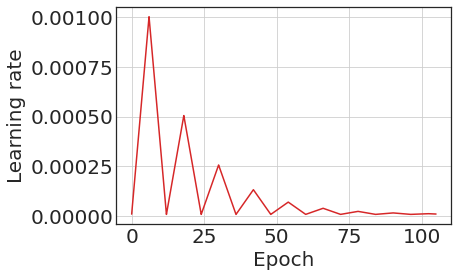

In [185]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

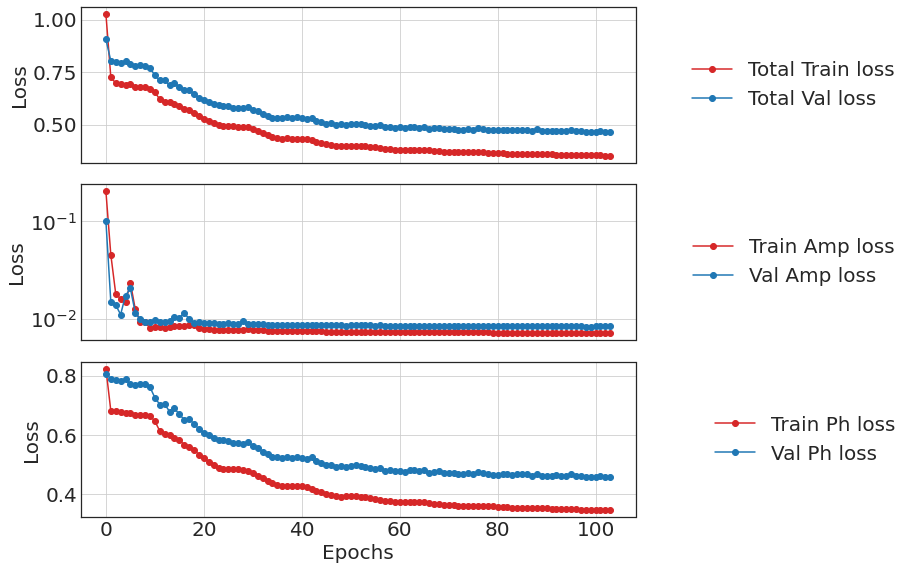

In [190]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].set_yscale('log')
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [191]:
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [192]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

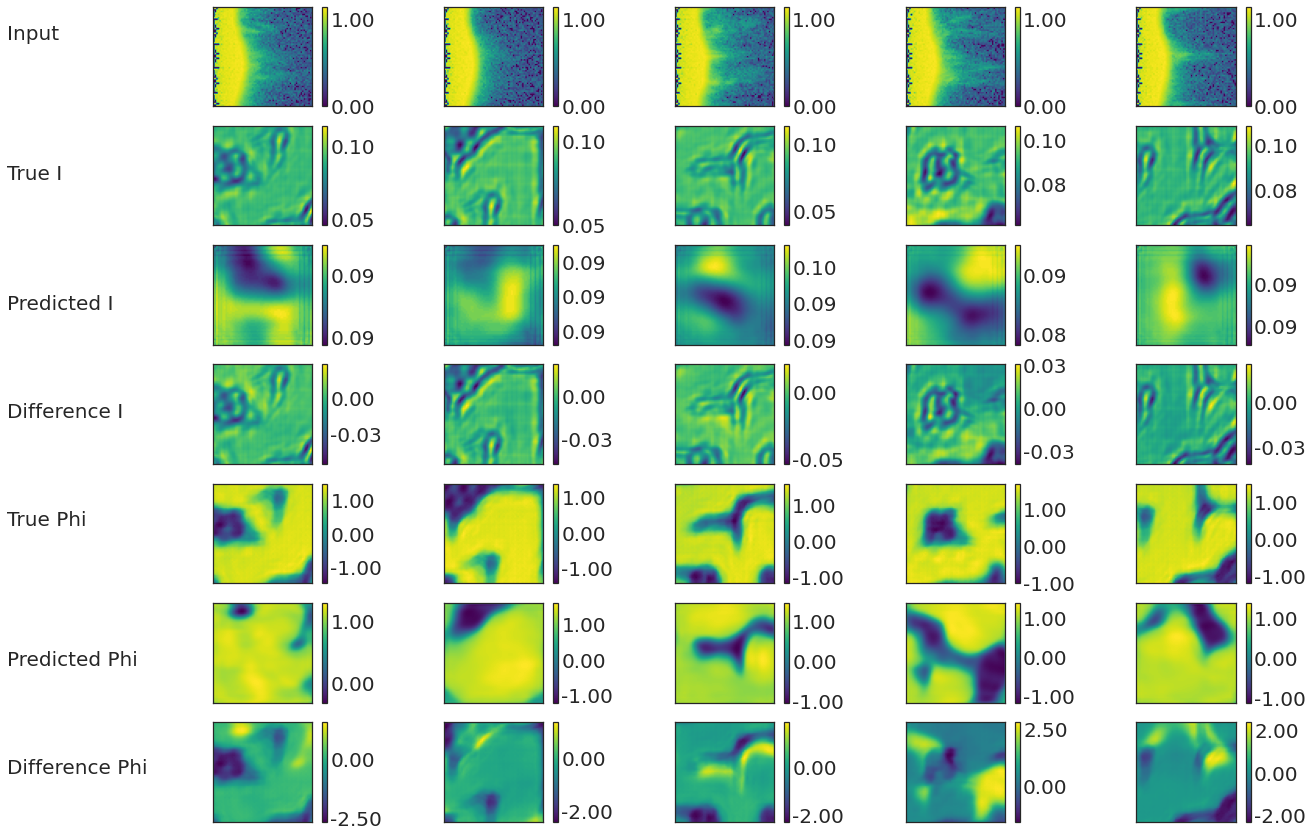

In [193]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [194]:
point_size = 3
overlap = 4*point_size

In [195]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [196]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [197]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [198]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

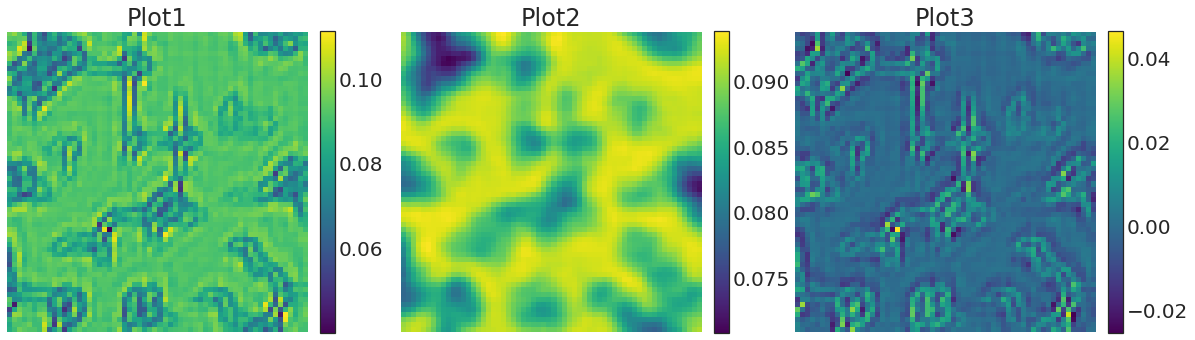

In [199]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

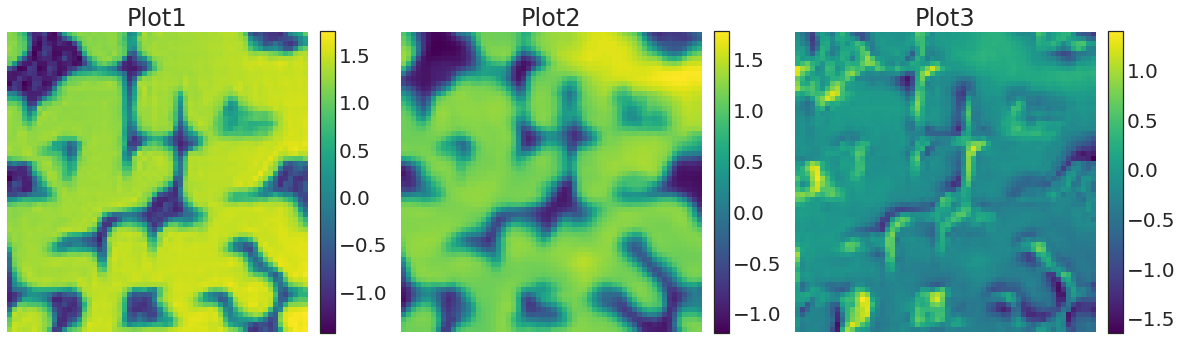

In [200]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [201]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  5.8848922492949674e-05
MSE in phase:  0.1583515712927947


In [202]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [203]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.35362749244953384, 8.846448005266927e-17)